In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196769
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=2,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using Hive (2.76s) 


KNeighborsClassifier(n_neighbors=2)

In [5]:
X_train

,volatile_acidity,chlorides,density,alcohol
0,0.400000,0.07100,0.994620,12.500000
1,0.320000,0.04300,0.992660,11.200000
2,0.300000,0.04600,0.997750,9.500000
3,0.400000,0.04600,0.990240,12.000000
5,0.260000,0.07100,0.998600,9.300000
...,...,...,...,...
5276,0.460000,0.07700,0.994800,10.600000
5278,0.210000,0.04000,0.990060,11.300000
5280,0.670000,0.29000,0.998400,9.000000
5281,0.400000,0.04200,0.998000,9.700000


In [6]:
y_train

,quality
0,8
1,6
2,6
3,7
5,6
...,...
5276,6
5278,6
5280,4
5281,5


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [8]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}, '4': {'precision': 0.039603960396039604, 'recall': 0.15384615384615385, 'f1-score': 0.06299212598425197, 'support': 26}, '5': {'precision': 0.4989339019189765, 'recall': 0.6358695652173914, 'f1-score': 0.5591397849462365, 'support': 368}, '6': {'precision': 0.5101522842639594, 'recall': 0.43506493506493504, 'f1-score': 0.4696261682242991, 'support': 462}, '7': {'precision': 0.37037037037037035, 'recall': 0.17964071856287425, 'f1-score': 0.24193548387096775, 'support': 167}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30}, 'accuracy': 0.44370860927152317, 'macro avg': {'precision': 0.23651008615822433, 'recall': 0.23407022878189243, 'f1-score': 0.22228226050429256, 'support': 1057}, 'weighted avg': {'precision': 0.45617747025381405, 'recall': 0.44370860927152317, 'f1-score': 0.43970837432533905, 'support': 1057}}


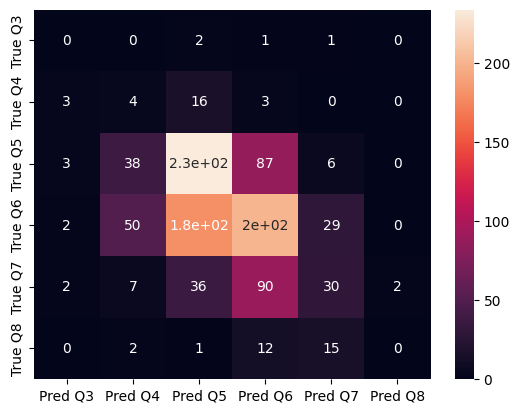

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Q3', 'True Q4', 'True Q5', 'True Q6', 'True Q7', 'True Q8'],
                     ['Pred Q3', 'Pred Q4', 'Pred Q5', 'Pred Q6', 'Pred Q7', 'Pred Q8'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/wine_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/196769/models/wine_model/1


Model(name: 'wine_model', version: 1)